# Assignment 1 : PGM

### Utils for plotting & Imports :

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

path = os.path.join(os.getcwd(), 'data')
def read_file(step, version): 
    return pd.read_csv(path + '/%s%s' % (step, version), sep = ' ', names = ['X1', 'X2', 'Y'])

### Utils for plotting : 
def plot_contour(X, Y, callable_, ax, step = 0.01):
    """
    This function plot the set of points definied by the arg callable_ which is the frontier eq of the probabilistic model
    callable_ can refer to lda, lin reg, logisitic reg.
    """
    abs_min, abs_max = X[:, 0].min(), X[:, 0].max()
    ord_min, ord_max = X[:, 1].min(), X[:, 1].max()
    xx = np.arange(abs_min, abs_max, step)
    yy = np.arange(ord_min, ord_max, step)
    XX, YY = np.meshgrid(xx, yy)
    Z = callable_(XX, YY)
    Z = np.squeeze(Z)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[1/2], alpha=0.5,
                linestyles=['--'])
    return Z

df_test = pd.DataFrame(columns = ['probabilistic_model', 'accuracy', 'dataset'])
df_train = pd.DataFrame(columns = ['probabilistic_model', 'accuracy', 'dataset'])
def plot_probabilistic_model(dataset, probabilistic_model):
    color = ['blue', 'red']
    dict_dataset_to_clean = {'lda' : 'LDA', 'logistic' : 'Logistic Regression', 'linear' : 'Linear Regression'}
    if dataset not in ['A', 'B', 'C']:
        raise ValueError("dataset must be in ['A', 'B', 'C'] ! ")
    if probabilistic_model not in ['lda', 'logistic', 'linear']:
        raise ValueError("probabilistic_model must be in ['lda', 'logistic', 'linear'] ! ")
    ## Load data
    train = read_file('train', dataset)
    test = read_file('test', dataset)
    X_train, y_train = train[['X1', 'X2']].values, train['Y'].values[:, None]
    X_test, y_test = test[['X1', 'X2']].values, test['Y'].values[:, None]
    ## Initialize model
    if probabilistic_model == 'lda' :
        estim = LDA()
    elif probabilistic_model == 'logistic' : 
        estim = LogisticRegression()
    elif probabilistic_model == 'linear' : 
        estim = LinearRegression()
    ## Fit model
    estim.fit(X_train, y_train)
    ## Generate predictions
    y_pred = estim.predict(X_test)
    y_pred_train = estim.predict(X_train)
    ## Compute missclassification
    classification_percentage, missclassified, greatly_classified = estim.score(y_test, y_pred)
    classification_percentage_train, missclassified_train, greatly_classified_train = estim.score(y_train, y_pred_train)
    global df_test, df_train
    df_test = df_test.append({'probabilistic_model' : probabilistic_model,  'accuracy' : classification_percentage, 'dataset' : dataset}, ignore_index = True)
    df_train = df_train.append({'probabilistic_model' : probabilistic_model,  'accuracy' : classification_percentage_train, 'dataset' : dataset}, ignore_index = True)
    ## Plot 
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(10,7))
    fig.suptitle('Classification using %s - Dataset %s' % (dict_dataset_to_clean[probabilistic_model], dataset), fontsize=16)
    
    ax1.scatter([],[], marker="o", c = 'Black', label="Correctly classified")
    ax1.scatter([],[], marker="X", c = 'Black', label="Wrongly classified")
    ax1.plot([], [], c = 'Black', label = 'P(y = 1|x) = 0.5')
    ## TRAIN : 
    
    for point in range(X_train.shape[0]):
        if point in missclassified_train:
            # Bad classified points :
            marker = 'X'
        else : 
            # Well classified points :
            marker = 'o'
        ax1.scatter(X_train[point, 0], 
                    X_train[point, 1], 
                    c = color[np.squeeze(y_train[point])],
                    marker = marker)
    plot_contour(X_train, y_train, estim.eq_frontier, ax1)
    ax1.set_title('TRAIN')
    for point in range(X_test.shape[0]):
        if point in missclassified:
            marker = 'X'
        else : 
            marker = 'o'
        ax2.scatter(X_test[point, 0], 
                    X_test[point, 1], 
                    c = color[np.squeeze(y_test[point])],
                    marker = marker)

    ax2.set_title('TEST')
    plot_contour(X_test, y_test, estim.eq_frontier, ax2)
    fig.legend()
    return estim
    


## Question 1

We consider the probabilistic model : $y \sim \mathcal{B}(\pi)$ and $x|y=i \sim \mathcal{N}(\mu_i, \Sigma)$

### Question 1.a :
$$
\begin{cases}
   p(y = 1) = \pi \\
   p(y = 0) = 1 - \pi
\end{cases}
$$
So we can rewrite as a condensed form: $p(y)=\pi^y(1-\pi)^{1-y}$ and $p(x|y) = \mathcal{N}(x,\mu_1, \Sigma)^y\mathcal{N}(x,\mu_0, \Sigma)^{1-y}$

Thus using Bayes rule : 
$p(x)= p(y)p(x|y) = \pi^y(1-\pi)^{1-y} \mathcal{N}(x,\mu_1, \Sigma)^y\mathcal{N}(x,\mu_0, \Sigma)^{1-y}$

Then we can write the log-likelihood of the model :

$$\mathcal{L}(x|\mu_0, \mu_1, \Sigma, \pi) = \sum_{i=1}^N \text{log} \{ p(x|\mu_0, \mu_1, \Sigma, \pi)\}$$ so

$$\mathcal{L}(x|\mu_0, \mu_1, \Sigma, \pi) = \sum_{i=1}^Ny_ilog(\pi \mathcal{N}(x_i, \mu_1, \Sigma)) + (1-y_i)log((1-\pi)\mathcal{N}(x_i, \mu_0, \Sigma))$$

We find the maximum of the log likehood with the first order conditions : 

$$ \begin{cases} \frac{\partial \mathcal{L}}{\partial \pi} = 0 \\ \frac{\partial \mathcal{L}}{ \partial \mu_0} = 0 \\ \frac{\partial \mathcal{L}}{\partial \mu_1} = 0 \\ \frac{\partial \mathcal{L}}{\partial \Sigma} = 0\end{cases}$$

The first equation writes : 
$$ \frac{\partial \mathcal{L}}{\partial \pi} = \sum_{i = 1}^N \{ \frac{y_i}{\pi} - \frac{1 - y_i}{1 - \pi} \} = 0 $$
Which gives : 
$$\hat{\pi} = \frac{1}{N} \sum_{i = 1}^N y_i$$ 
The second equation writes : 
$$ \frac{\partial \mathcal{L}}{\partial \mu_0} = \sum_{i = 1}^N \frac{1 - y_i}{\pi}\Sigma^{-1}(x_i - \mu_0) = 0 $$
So we have : 
$$ \hat{\mu_0} = \frac{\sum_{i = 1}^N (1 - y_i) x_i}{\sum_{i = 1}^N (1 - y_i)}$$

Similarly, we have : 
$$ \hat{\mu_1} = \frac{\sum_{i = 1}^N y_i x_i}{\sum_{i = 1}^N y_i}$$

The last equation is a bit more tricky, we rewrite $\mathcal{L}(x|\mu_0, \mu_1, \Sigma, \pi)$ as :
$$ \mathcal{L}(x|\mu_0, \mu_1, \Sigma, \pi) = \sum_{i=1}^N y_i \text{log}\pi + y_i \text{log}\mathcal{N}(x_i, \mu_1, \Sigma)) + (1-y_i)\text{log}(1-\pi) + (1 - y_i)\text{log}\mathcal{N}(x_i, \mu_0, \Sigma)$$

Let's compute $\frac{\partial}{\partial \Sigma^{-1}} \text{log}\mathcal{N}(x, \mu, \Sigma) : $

$$  \text{log}\mathcal{N}(x, \mu, \Sigma) =  -\text{log}(2\pi) + \frac{1}{2}\text{log}(|\Sigma^{-1}|) - \frac{1}{2} (x - \mu)^T\Sigma^{-1}(x - \mu)$$

Thus : 
$$ \frac{\partial}{\partial \Sigma^{-1}} \text{log}\mathcal{N}(x, \mu, \Sigma) = \frac{1}{2}\frac{1}{|\Sigma^{-1}|}\frac{\partial |\Sigma^{-1}| }{\partial \Sigma^{-1}} - \frac{1}{2}(x - \mu)(x - \mu)^T = 
\frac{1}{2}\frac{1}{|\Sigma^{-1}|}|\Sigma^{-1}|\Sigma^T - \frac{1}{2}(x - \mu)(x - \mu)^T = 
\frac{1}{2}\Sigma^T - \frac{1}{2}(x - \mu)(x - \mu)^T
$$

So if we get back to our equation, we have : 


$$ \sum_{i=1}^N \left[ y_i \left\{ \frac{1}{2}\Sigma^T - \frac{1}{2}(x_i - \mu_1)(x_i - \mu_1)^T\right\}  + (1 - y_i)\left\{ \frac{1}{2}\Sigma^T - \frac{1}{2}(x_i - \mu_0)(x_i - \mu_0)^T\right\}\right] = 0$$ 



$$  N\Sigma^T -  \sum_{i=1}^N \left\{ y_i  (x_i - \mu_1)(x_i - \mu_1)^T  + (1 - y_i)(x_i - \mu_0)(x_i - \mu_0)^T\right\} = 0$$ 
So finally : 

$$  \hat{\Sigma} = \frac{1}{N}\sum_{i=1}^N \left\{ y_i  (x_i - \hat{\mu_1})(x_i - \hat{\mu_1})^T  + (1 - y_i) (x_i - \hat{\mu_0})(x_i - \hat{\mu_0})^T\right\}$$ 

### Question 1.b :  

We have $$ p(y = 1|x) = \frac{p(y = 1, x)}{p(x)} = \frac{p(x|y = 1)p(y = 1)}{p(x)} = \frac{p(x|y = 1)p(y = 1)}{p(x|y = 1)p(y = 1) + p(x|y = 0)p(y = 0)} = \frac{1}{1 + \frac{p(x|y = 0)p(y = 0)}{p(x|y = 1)p(y = 1)}} = \frac{1}{1 + \text{exp(-X)}}$$ 
$$ \text{With } X = \text{log}\left(\frac{p(x|y = 1)p(y = 1)}{p(x|y = 0)p(y = 0)}\right)$$

Let's compute $X$ more precisely: 
$$ X = \text{log}\left(\frac{\pi\mathcal{N}(x,\mu_1, \Sigma)}{(1 - \pi)\mathcal{N}(x,\mu_0, \Sigma)}\right) = \text{log}\left(\frac{\pi}{1 - \pi}\right) + \text{log}\left(\frac{\mathcal{N}(x,\mu_1, \Sigma)}{\mathcal{N}(x,\mu_0, \Sigma)} \right) = \text{log}\left(\frac{\pi}{1 - \pi}\right) + \frac{1}{2}(x - \mu_1)^T\Sigma^{-1}(x - \mu_1) - \frac{1}{2}(x - \mu_0)^T\Sigma^{-1}(x - \mu_0)$$



$$ X = \text{log}\left(\frac{\pi}{1 - \pi}\right) + (\mu_0 - \mu_1)^T\Sigma^{-1}x + \frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 - \frac{1}{2}\mu_0^T\Sigma^{-1}\mu_0$$

In the logistic regression framework, $p(y = 1|x) = \frac{1}{1 + \text{exp}(-X)}$, with $X = w^Tx + \beta$.

In the LDA framework, we have the same form, with $w = (\Sigma^{-1})^T(\mu_0 - \mu_1)$, $\beta = \text{log}\left(\frac{\pi}{1 - \pi}\right) + \frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 - \frac{1}{2}\mu_0^T\Sigma^{-1}\mu_0$

## Question 1.c

In [2]:
import copy
def g(t):
    """
    logistic function
    """
    return 1 / (1 + np.exp(-t))

class LDA():
    """
        LDA Class.
    """
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        N = Y.shape[0]
        pi = np.sum(Y) / N
        mu_0 = np.sum((1-Y) * X, axis = 0) / np.sum(1-Y)
        mu_1 = np.sum(Y * X, axis = 0) / np.sum(Y)
        sigma = np.einsum('ki,kj->ij', Y*(X - mu_1), (X - mu_1)) + np.einsum('ki,kj->ij', (1 - Y)*(X - mu_0), (X - mu_0))
        sigma = sigma / N
        self.pi = pi
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.sigma = sigma
        
    def predict(self, X):
        inv_sigma = np.linalg.inv(self.sigma)
        t = np.log(self.pi/(1 - self.pi)) + (((self.mu_0 - self.mu_1).T).dot(inv_sigma)).dot(X.T) + 0.5*self.mu_1.T.dot(inv_sigma).dot(self.mu_1) - 0.5*self.mu_0.T.dot(inv_sigma).dot(self.mu_0)
        return g(t) <= 0.5
    
    def compute(self, X):
        inv_sigma = np.linalg.inv(self.sigma)
        t = np.log(self.pi/(1 - self.pi)) + (((self.mu_0 - self.mu_1).T).dot(inv_sigma)).dot(X.T) + 0.5*self.mu_1.T.dot(inv_sigma).dot(self.mu_1) - 0.5*self.mu_0.T.dot(inv_sigma).dot(self.mu_0)
        return g(t)
        
    
    def eq_frontier(self, x_0, x_1):
        x = np.stack([x_0, x_1], axis = 1)
        inv_sigma = np.linalg.inv(self.sigma)
        t = np.log(self.pi/(1 - self.pi)) + (((self.mu_0 - self.mu_1).T).dot(inv_sigma)).dot(x) + 0.5*self.mu_1.T.dot(inv_sigma).dot(self.mu_1) - 0.5*self.mu_0.T.dot(inv_sigma).dot(self.mu_0)
        return g(t)
    
    def score(self, y_true, y_pred):
        if y_true.ndim > 1:
            y_true = copy.deepcopy(y_true[:, 0])
        if y_pred.ndim > 1:
            y_pred = copy.deepcopy(y_pred[:, 0])
        classification_percentage = (y_pred == y_true).sum()/len(y_true)
        missclassified = np.where(y_pred != y_true)[0]
        greatly_classified = np.where(y_pred == y_true)[0]
        return classification_percentage, missclassified, greatly_classified


pi learned :  0.48
mu_0 learned :  [10.73248858 10.93983367]
mu_1 learned :  [11.03264581  5.99294053]
sigma learned :  [[0.58821974 0.13912842]
 [0.13912842 0.81959919]]


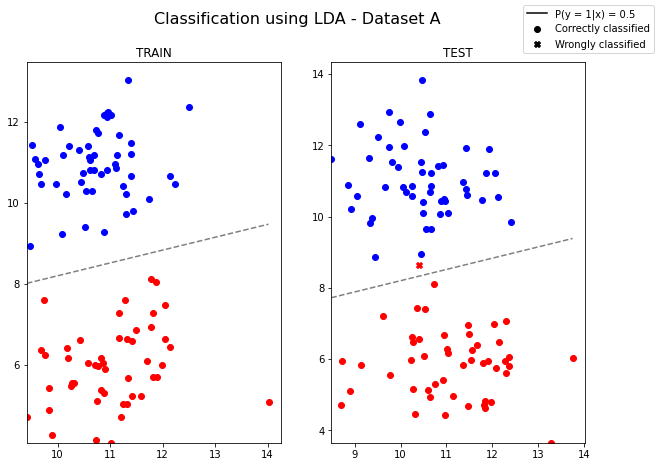

In [3]:
lda_A = plot_probabilistic_model('A', 'lda')
print('pi learned : ', lda_A.pi)
print('mu_0 learned : ', lda_A.mu_0)
print('mu_1 learned : ', lda_A.mu_1)
print('sigma learned : ', lda_A.sigma)

pi learned :  0.55
mu_0 learned :  [10.58256756 11.17169818]
mu_1 learned :  [11.24757662  6.095283  ]
sigma learned :  [[1.64391088 0.70139847]
 [0.70139847 2.0605845 ]]


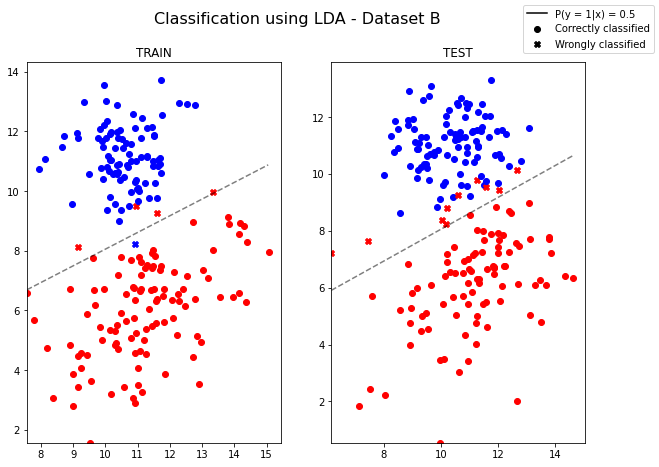

In [4]:
lda_B = plot_probabilistic_model('B', 'lda')
print('pi learned : ', lda_B.pi)
print('mu_0 learned : ', lda_B.mu_0)
print('mu_1 learned : ', lda_B.mu_1)
print('sigma learned : ', lda_B.sigma)

pi learned :  0.4166666666666667
mu_0 learned :  [10.6192273  10.83868653]
mu_1 learned :  [11.18463199  6.04249315]
sigma learned :  [[ 1.27823018 -0.06243809]
 [-0.06243809  1.66584186]]


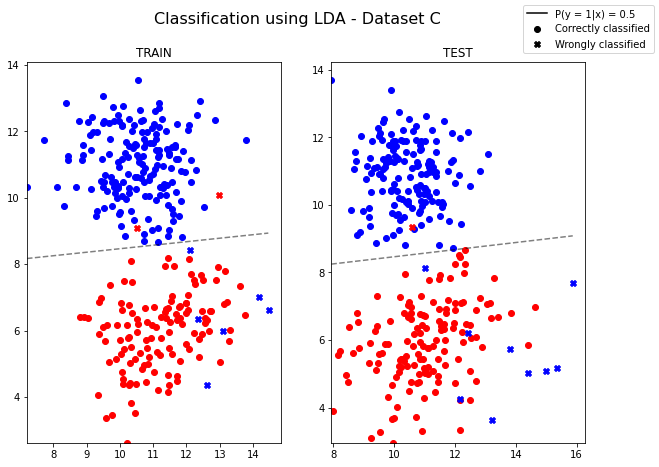

In [5]:
lda_C = plot_probabilistic_model('C', 'lda')
print('pi learned : ', lda_C.pi)
print('mu_0 learned : ', lda_C.mu_0)
print('mu_1 learned : ', lda_C.mu_1)
print('sigma learned : ', lda_C.sigma)

# Question 2
## Question 2.a

The logistic regression model writes as : 
$$y_i|x_i, w, \beta \sim \mathcal{B}(g(x_i^Tw + \beta)) \text{ and } g(x) = \frac{1}{1 + e^{-t}}$$
Thus we have, 
$$\begin{cases} p(y_i = 1 | x_i) = g(w^T x_i + \beta) \\ 
 p(y_i = 0 | x_i) = 1 - g(w^T x_i + \beta) \end{cases}$$
 

This can be summarized as : 
$$ p(y_i | x_i) = p(y_i = 1 | x_i)^{y_i} p(y_i = 0 | x_i)^{1 - y_i} =  g(w^T x_i + \beta)^{y_i} (1 - g(w^T x_i + \beta))^{1 - y_i}$$ 
We can write the log-likelihood of the model : 
$$ \mathcal{L}(x, y|w, \beta) = \sum_{i=1}^N \text{log} \{ p(y_i | x_i)\}$$

$$ \mathcal{L}(x, y|w, \beta) = \sum_{i=1}^N (1 - y_i)\text{log}(1 - g(w^T x_i + \beta))  + y_i \text{log}(g(w^T x_i + \beta))$$

By using : 
$$\begin{cases} \text{log}(g(t)) = -\text{log}(1 + e^{-t})\\ 
 \text{log}(1 - g(t)) = -t - \text{log}(1 + e^{-t}) \end{cases}$$
We have : 
$$ \mathcal{L}(x, y|w, \beta) = \sum_{i=1}^N -(1 - y_i)(w^T x_i + \beta + \text{log}(1 + e^{-(w^T x_i + \beta)}))  - y_i \text{log}(1 + e^{-(w^T x_i + \beta)})) = \sum_{i=1}^N (y_i - 1)(w^T x_i + \beta) - \text{log}(1 + e^{-(w^T x_i + \beta)})$$ 



We write the first order conditions to maximize the log-likelihood :
$$ \begin{cases} \frac{\partial \mathcal{L}}{\partial w} = 0 
 \\ \frac{\partial \mathcal{L}}{ \partial \beta} = 0 \end{cases}$$
 
$$ \begin{cases} \sum_{i=1}^N y_i - 1  + \frac{e^{-(w^T x_i + \beta)}}{1 + e^{-(w^T x_i + \beta)}} = \sum_{i=1}^N y_i  - g(w^T x_i + \beta) =  0 
 \\ \sum_{i=1}^N x_i(y_i - 1)  + \frac{x_i e^{-(w^T x_i + \beta)}}{1 + e^{-(w^T x_i + \beta)}} = \sum_{i=1}^N x_i (y_i -g(w^T x_i + \beta)) = 0
 \end{cases}$$
 
These equations doesn't reduce to a closed form. We need to use a newton raphson algorithm to find the zeros of the function : 
 $$ f : (w, \beta) \mapsto \begin{pmatrix} \sum_{i=1}^N x_i (y_i -g(w^T x_i + \beta)) \\
                                           \sum_{i=1}^N y_i  - g(w^T x_i + \beta)
                           \end{pmatrix} \in \mathbb{R}^{d + 1} \text{ where } d \text{ is the dimension of each } x_i $$ 


We need to compute the hessian of $f$ : 

$$ \begin{cases} 
\frac{\partial f_{1..d}}{\partial w}= -\sum_{i=1}^N  x_i x_i^T  g(w^T x_i + \beta)g(-(w^T x_i + \beta)) \in \mathbb{R}^{d, d} \\
\frac{\partial f_{1..d}}{\partial \beta}= -\sum_{i=1}^N  x_i g(w^T x_i + \beta)g(-(w^T x_i + \beta)) \in \mathbb{R}^{d}\\
\frac{\partial f_{d + 1}}{\partial w}= -\sum_{i=1}^N  x_i g(w^T x_i + \beta)g(-(w^T x_i + \beta)) \in \mathbb{R}^{d} \\
\frac{\partial f_{d + 1}}{\partial \beta}= -\sum_{i=1}^N g(w^T x_i + \beta)g(-(w^T x_i + \beta)) \in \mathbb{R} \\
 \end{cases}$$

In [6]:
from scipy import optimize
import matplotlib.pyplot as plt

def f(z, X, Y):
    """
    Define the function at which we want to find the zeros
    """
    w = z[:-1]
    beta = z[-1]
    term_1_d = (X*(Y - g(X.dot(w) + beta))).sum(axis = 0)
    term_d_1 = (Y - g(X.dot(w) + beta)).sum(axis = 0)
    return np.hstack((term_1_d, term_d_1))[:, None]  

def hess_f(z, X, Y):
    """
    Compute the Hessian of the function f
    """
    d = z.shape[0]
    w = z[:-1]
    beta = z[-1]
    hess = np.zeros((d, d))
    hess[:-1, :-1] = - np.einsum('ki,kj->ij', X*g(X.dot(w) + beta), X*g(-(X.dot(w) + beta)))
    hess[:-1, [-1]] = - np.einsum('ij,ik->kj', g(X.dot(w) + beta)*g(-(X.dot(w) + beta)), X)
    hess[[-1], :-1] = hess[:-1, [-1]].T
    hess[-1, -1] = - np.dot(g(X.dot(w) + beta).T, g(-(X.dot(w) + beta)))
    return hess

def NewtonRaphson(z_ini, f, fprime, tol):
    """
    Create Newton Raphson algorithm to find the zeros of a fonction f. 
    Args : 
        z_ini : starting point of the algorithm
        f : function f
        f_prime : hessian of f
        tol : tolerance
    Returns : 
        z_current : approximative zero of f
    """
    z_current = z_ini
    while np.linalg.norm(f(z_current)) > tol:
        hess = fprime(z_current)
        inv_hess = np.linalg.solve(hess, np.eye(hess.shape[0]))
        z_new = z_current - inv_hess.dot(f(z_current))
        z_current = z_new
    return z_current
   
### Logisitc Regression Class
class LogisticRegression():
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        z_ini = np.zeros((3, 1))
        z_final = NewtonRaphson(z_ini, f = lambda z : f(z, X, Y), fprime = lambda z : hess_f(z, X, Y), tol = 1e-8)
        w_final, beta_final = z_final[:-1], z_final[-1]
        self.w = w_final
        self.beta = beta_final
        
    def predict(self, X):
        x_0 = X[:, 0].copy()
        x_1 = X[:, 1].copy()
        proba_success = g(x_0*self.w[0] + x_1*self.w[1] + self.beta)
        label_successes = (proba_success > 0.5)
        return label_successes
    
    def compute(self, X):
        x_0 = X[:, 0].copy()
        x_1 = X[:, 1].copy()
        proba_success = g(x_0*self.w[0] + x_1*self.w[1] + self.beta)
        return proba_success
        
    
    def score(self, y_true, y_pred):
        if y_true.ndim > 1 : 
            y_true = y_true[:, 0].copy()
        classification_percentage = (y_pred == y_true).sum()/len(y_true)
        missclassified = np.where(y_pred != y_true)[0]
        greatly_classified = np.where(y_pred == y_true)[0]
        return classification_percentage, missclassified, greatly_classified
        
    def eq_frontier(self, x_0, x_1):
        return g(x_0*self.w[0] + x_1*self.w[1] + self.beta)


## Question 2.b

We characterize the separating hyperplane as : $p(y = 1|x) = \frac{1}{2}$, ie  $g(w^T x + \beta) = \frac{1}{2}$

## Question 2.c

w learned :  [[  7.46905866]
 [-28.7355171 ]]
beta learned :  [165.70600275]


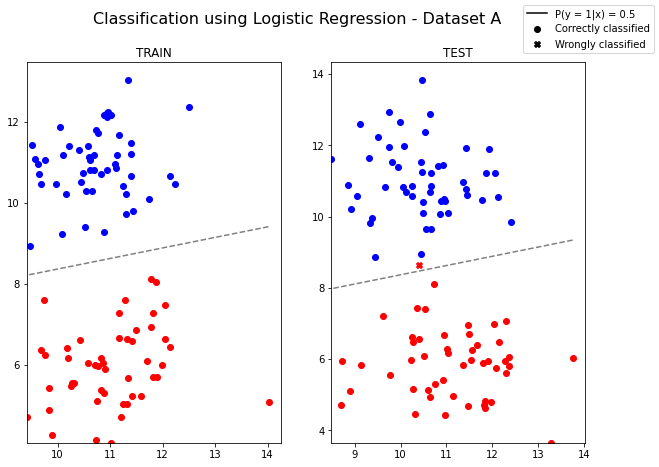

In [7]:
log_A = plot_probabilistic_model('A', 'logistic')
print('w learned : ', log_A.w)
print('beta learned : ', log_A.beta)

w learned :  [[ 1.84239524]
 [-3.71393779]]
beta learned :  [13.43016214]


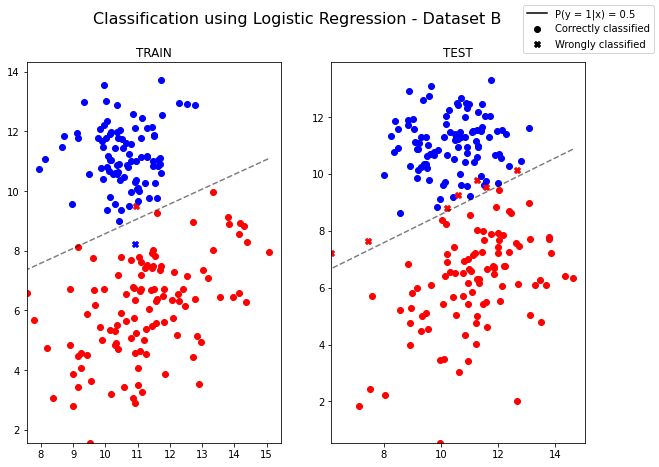

In [8]:
log_B = plot_probabilistic_model('B', 'logistic')
print('w learned : ', log_B.w)
print('beta learned : ', log_B.beta)

w learned :  [[-0.27693433]
 [-1.91419825]]
beta learned :  [18.80703913]


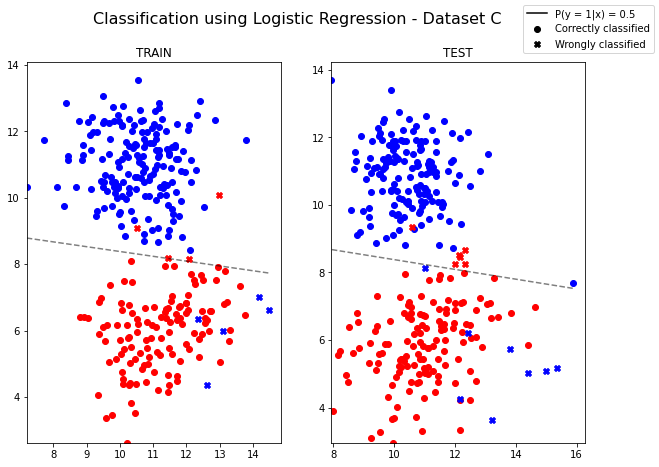

In [9]:
log_C = plot_probabilistic_model('C', 'logistic')
print('w learned : ', log_C.w)
print('beta learned : ', log_C.beta)

# Question 3 : Linear Model

## Question 3.a

We consider the linear model as follows : 

$y_i = w^T x_i + \beta + \epsilon_i$, where  for $i = 1, ..., N, \epsilon_i \sim \mathcal{N}(0, \sigma^2)$

Thus we have the conditionnal probability : 

$$ p(y_i|x_i; w, \beta, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}\text{exp}\{-\frac{1}{2\sigma^2}(y_i - w^T x_i - \beta)^2\}$$ 

We can write the likelihood of the model (as the noise random variables $\epsilon_i$ are independant and identically distributed).

$$ \mathcal{L}(x, y|w, \beta, \sigma) = \sum_{i=1}^N \text{log} \{ p(y_i|x_i; w, \beta, \sigma)\}$$

$$ \mathcal{L}(x, y|w, \beta, \sigma) = \sum_{i=1}^N \text{log}\left\{ \frac{1}{\sigma\sqrt{2\pi}}\text{exp}\{-\frac{1}{2\sigma^2}(y_i - w^T x_i - \beta)^2\} \right\}$$




$$ \mathcal{L}(x, y|w, \beta, \sigma) = -N\text{log}(\sigma\sqrt{2\pi}) - \sum_{i=1}^N \frac{1}{2\sigma^2}\left\{(y_i - w^T x_i - \beta)^2 \right\}$$

Which can be written using matrix notation, where $X = \begin{pmatrix} x_0 \\ ... \\ x_N \end{pmatrix}$: 
$$ \mathcal{L}(x, y|w, \beta, \sigma) = -N\text{log}(\sigma\sqrt{2\pi}) - \frac{1}{2\sigma^2} \|Y - Xw - \beta\mathbb{1}\|^2_2 $$

We write the first order conditions to maximize the log-likelihood :
$$ \begin{cases} \frac{\partial \mathcal{L}}{\partial w} = 0 
 \\ \frac{\partial \mathcal{L}}{ \partial \beta} = 0 
 \\ \frac{\partial \mathcal{L}}{ \partial \sigma} = 0\end{cases}$$

Which writes : 
$$ \begin{cases} X^T(Y - Xw - \beta\mathbb{1}) = 0
\\ \mathbb{1}^T \mathbb{1} \beta - Y^T\mathbb{1} + (Xw)^T\mathbb{1} = 0
\\ \sigma^2 = \frac{1}{N}\|Y - Xw - \beta\mathbb{1}\|^2_2
\end{cases}$$

Let's denote $\tilde X = \begin{pmatrix} X && \mathbb{1}_n \end{pmatrix}$ and $\tilde w = \begin{pmatrix} w \\ \beta \end{pmatrix}$. We can check that : 
$$ \tilde X^T \tilde X \tilde w = \tilde{X}^T Y \iff \begin{pmatrix} X && \mathbb{1}_n \end{pmatrix}^T\begin{pmatrix} X && \mathbb{1}_n \end{pmatrix}\begin{pmatrix} w \\ \beta \end{pmatrix}  = \begin{pmatrix} X && \mathbb{1}_n \end{pmatrix}^T Y $$ 
$$\iff\begin{cases} X^TXw + \beta X^T\mathbb{1}_n = X^TY \\
\mathbb{1}_n^TXw + \beta \mathbb{1}_n^T\mathbb{1}_n = \mathbb{1}_n^TY \end{cases}\iff
\begin{cases} X^T(Y - Xw - \beta\mathbb{1}_n) = 0
\\ \mathbb{1}_n^T \mathbb{1}_n \beta - Y^T\mathbb{1}_n + (Xw)^T\mathbb{1}_n = 0\end{cases} $$


We can rewrite the above system as : 
$$ \begin{cases} \tilde X^T \tilde X \tilde w = \tilde{X}^T Y
\\ \sigma^2 = \frac{1}{N}\|Y - \tilde X \tilde w \|^2_2
\end{cases}$$



$$ \begin{cases} 
    \begin{pmatrix} \hat w \\\hat \beta \end{pmatrix} = (\tilde X^T \tilde X)^{-1}\tilde{X}^T Y\\
    \hat{\sigma^2} = \frac{1}{N}\|Y - X\hat{w} - \hat{\beta}\mathbb{1}\|^2_2
   \end{cases}
$$

In [10]:
class LinearRegression():
    def __init__(self):
        pass
    def fit(self, X, Y):
        N, d = X.shape
        ## Solve Normal equations
        X_tilde = np.hstack([X, np.ones((N, 1))])
        matrix_to_be_inv = X_tilde.T.dot(X_tilde)
        inverted_matrix = np.linalg.solve(matrix_to_be_inv, np.eye(d + 1))
        w_tilde = inverted_matrix.dot((X_tilde.T).dot(Y))
        w_ = w_tilde[:d]
        beta_ = w_tilde[d]
        ## Store variables : 
        sigma_2 = np.linalg.norm(Y - X_tilde.dot(w_tilde))/N
        self.w = w_
        self.beta = beta_
        self.sigma = np.sqrt(sigma_2)
    
    def predict(self, X):
        proba_half = (X).dot(self.w) + self.beta
        labels = (proba_half >= 0.5)
        return labels
    
    def score(self, y_true, y_pred):
        if y_true.ndim > 1:
            y_true = y_true[:, 0]
        if y_pred.ndim > 1:
            y_pred = y_pred[:, 0]
        classification_percentage = (y_pred == y_true).sum()/len(y_true)
        missclassified = np.where(y_pred != y_true)[0]
        greatly_classified = np.where(y_pred == y_true)[0]
        return classification_percentage, missclassified, greatly_classified
    
    def eq_frontier(self, x_0, x_1):
        x = np.stack([x_0, x_1], axis = 1)
        return (self.w.T).dot(x) + self.beta


## Question 3.b

$p(y = 1|x; w, \beta, \sigma) = \frac{1}{2} \iff p(y = 1|x; w, \beta, \sigma) = p(y = 0|x; w, \beta, \sigma) \iff 
\text{log}(p(y = 1|x; w, \beta, \sigma)) = \text{log}(p(y = 0|x; w, \beta, \sigma))$

And :  $p(y = 1|x; w, \beta, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}\text{exp}\{-\frac{1}{2\sigma^2}(1 - w^T x - \beta)^2\}$

Thus :
$p(y = 1|x; w, \beta, \sigma) = \frac{1}{2} \iff (1 - w^T x - \beta)^2 = (w^T x + \beta)^2 \iff 1 -2w^Tx -2\beta = 0 \iff w^Tx + \beta = \frac{1}{2}$


## Question 3.c

w learned :  [[ 0.05582438]
 [-0.17636636]]
beta learned :  [1.38345774]
sigma learned :  0.1289510476222941


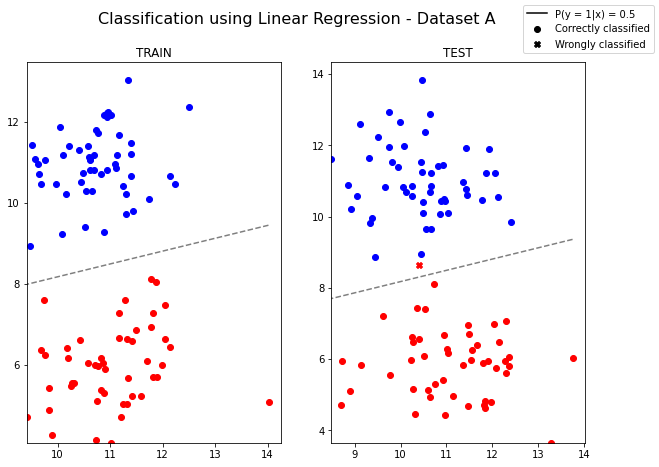

In [11]:
lin_A = plot_probabilistic_model('A', 'linear')
print('w learned : ', lin_A.w)
print('beta learned : ', lin_A.beta)
print('sigma learned : ', lin_A.sigma)

w learned :  [[ 0.08258172]
 [-0.14757517]]
beta learned :  [0.88249984]
sigma learned :  0.12478468837503373


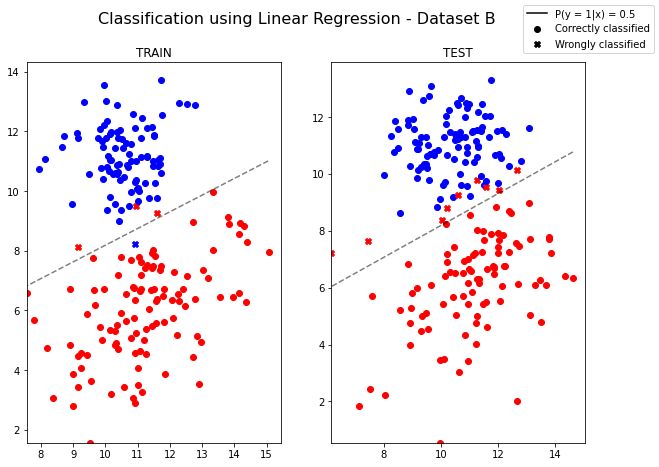

In [12]:
lin_B = plot_probabilistic_model('B', 'linear')
print('w learned : ', lin_B.w)
print('beta learned : ', lin_B.beta)
print('sigma learned : ', lin_B.sigma)

w learned :  [[ 0.01675461]
 [-0.15897174]]
beta learned :  [1.64015206]
sigma learned :  0.11659018600907319


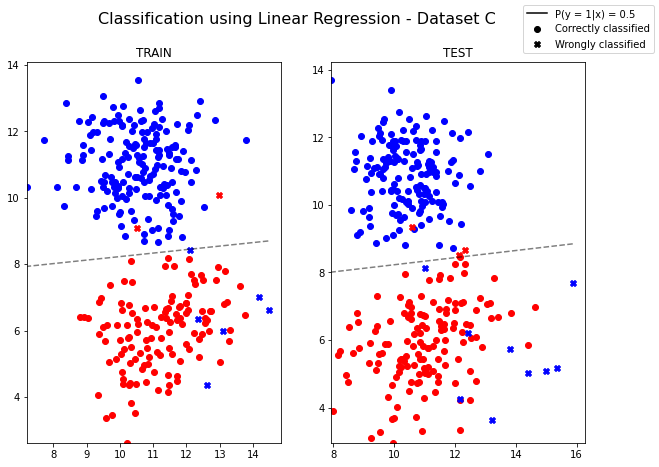

In [13]:
lin_C = plot_probabilistic_model('C', 'linear')
print('w learned : ', lin_C.w)
print('beta learned : ', lin_C.beta)
print('sigma learned : ', lin_C.sigma)

## Question 4
Let's compare the three methods.

In [14]:
df_train = df_train.set_index(['probabilistic_model', 'dataset']).rename(columns = {'accuracy': 'Accuracy train'})
df_test = df_test.set_index(['probabilistic_model', 'dataset']).rename(columns = {'accuracy': 'Accuracy test'})
display(df_train.join(df_test).round(3))

Accuracy train  Accuracy test
probabilistic_model dataset                               
lda                 A                 1.000          0.990
                    B                 0.975          0.950
                    C                 0.973          0.967
logistic            A                 1.000          0.990
                    B                 0.990          0.965
                    C                 0.970          0.953
linear              A                 1.000          0.990
                    B                 0.980          0.955
                    C                 0.973          0.960



* For the first dataset, the data is easily separable, so the model can split the two classes without any error.
    All of them have an accuracy of 100% on the train set and 99% on the test set. We can see that only one point is misclassified on the test set.

* For the dataset B, the Logistic Regression has the best training error, with an accuracy of 99%. 
    However, the two others models show 98% accuracy (linear) and 99% (logistic). 
    In the test test, the Logistic regression has still the best error : 96.5% while Linear has 95.5% and Lda has 95%. Hence the best model for this dataset seems to be definitely the **Logistic Regression**

* For the dataset C, Both linear and lda have the same training accuracy : 97.33% and logistic has 97%.
    However, on the test set, lda shows the best accuracy 96.66%, whereas linear is the second best : 96%, and logistic regression is the last : 95.33%. Thus, no clear model seems to distinguish from the others.
    
As a conclusion, the best model seems to depend on the dataset, and there is no clear model to use. In order to evaluate our models, we shall focus on the test accuracy because that's an unbiased way to see the performance. In order to be more robust we could use a cross validation and use the mean test scores as a metric for the overall performance.

# Part 2

## Question 1
We consider the $K$ components Gaussian mixture model : 
$p(x|\pi, \theta) = \sum_{k = 1}^K\pi_k\mathcal{N}(x; \mu_k, \Sigma_k)$, where $\theta = (\mu_k, \Sigma_k)_k$ and $\pi$ belongs to the K-simplex.


We want to maximize the log likelihood : 

$$ \mathcal{L}\left\{ (x_i)_i; \pi, (\mu_k, \Sigma_k)_k\right\} = \sum_{i = 1}^N \text{log} \left\{ p(x_i; (\mu_k, \Sigma_k)_k)\right\} = \sum_{i = 1}^N \text{log} \left\{ \sum_{k = 1}^K\pi_k\mathcal{N}(x; \mu_k, \Sigma_k) \right\}$$.

But, this quantity is hard to optimize. 
Let's introduce intermediate variables $(Z_i)_i$.

$Z_{ik} = 1$ means the point $x_i$ come from the component $k$.

$ \forall i \in \{ 1 \dots N\}, Z_i \sim Z = \mathcal{M}(1, \pi)$ , where $(Z_i)_i$ are iid.

Thus $\mathbb{P}(Z = z_k) = \pi_k$, and we can write : $p(z) = \mathbb{P}(Z = z) = \prod_{k = 1}^{K}\pi_k^{z_k}$

And $ \forall i \in \{ 1 \dots N\}, X_i|Z_{ik} \sim \mathcal{N}(\mu_k, \Sigma_k)$.

Thus, $$p(x|z, (\mu_k, \Sigma_k)_k) = \prod_{k = 1}^K\mathcal{N}(x; \mu_k, \Sigma_k)^{ z_k}$$



And by Bayes rule : 

$p(x, z; (\mu_k, \Sigma_k)_k) = \prod_{k = 1}^{K}\pi_k^{z_k} \prod_{k = 1}^K \mathcal{N}(x; \mu_k, \Sigma_k)^{z_k} = \prod_{k = 1}^{K}\pi_k^{z_k}\mathcal{N}(x; \mu_k, \Sigma_k)^{z_k}$

We can now write the "complete" log-likelihood : 
$$ \mathcal{L}((x_i, z_i)_i; \pi, (\mu_k, \Sigma_k)_k) = \sum_{i = 1}^N \text{log} \{ p(x_i, z_i; (\mu_k, \Sigma_k)_k)\} = \sum_{i = 1}^N \sum_{k = 1}^K z_{ik} \text{log}(\pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k))$$



Moreover,we can see that : 
$$\mathcal{L}((x_i)_i; \pi, (\mu_k, \Sigma_k)_k) = \mathcal{L}((x_i, z_i)_i; \pi, (\mu_k, \Sigma_k)_k) - \sum_{i = 1}^N \text{log}(p(z_i|x_i; \pi, (\mu_k, \Sigma_k)_k)$$
 

Let's write $\theta = (\pi, (\mu_k, \Sigma_k)_k)$, the above rewrites :
$$\mathcal{L}((x_i)_i; \theta) = \mathcal{L}((x_i, z_i)_i; \theta) - \sum_{i = 1}^N \text{log}(p(z_i|x_i; \theta)$$

We can see that, the left term does not depend on $z$ so we can take the expectation on both sides with respect to z with some current parameters $\theta_c$
$$\mathcal{L}((x_i)_i; \theta) = \mathbb{E}_z\left[\mathcal{L}((x_i, z_i)_i;\theta)|\theta_c, (x_i)_i \right] -  \mathbb{E}_z\left[\sum_{i = 1}^N \text{log}(p(z_i|x_i; \theta)|\theta_c, (x_i)_i\right] = Q(\theta; \theta_c) + H(\theta, \theta_c)$$

Where : $\begin{cases} 
Q(\theta; \theta_c) = \mathbb{E}_z\left[\mathcal{L}((x_i, z_i)_i;\theta)|\theta_c, (x_i)_i \right] \\
H(\theta, \theta_c) = -\mathbb{E}_z\left[\sum_{i = 1}^N \text{log}(p(z_i|x_i; \theta)|\theta_c, (x_i)_i\right]\end{cases}$

The algorithm EM consists in iteratively maximizing $Q$ as : $$ \theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$$

By doing so : $\mathcal{L}((x_i)_i; \theta_t)$ converges to a local maxima.

_**Let's prove that :**_

The above equality is true for every $\theta$, for instance $\theta_c$. Then we have : 
$$\begin{cases}
\mathcal{L}((x_i)_i; \theta) = Q(\theta; \theta_c) + H(\theta, \theta_c)\\
\mathcal{L}((x_i)_i; \theta_c) = Q(\theta_c; \theta_c) + H(\theta_c, \theta_c)
\end{cases}$$

If we subract the two equations : 
$$\mathcal{L}((x_i)_i; \theta) - \mathcal{L}((x_i)_i; \theta_c) = Q(\theta; \theta_c) - Q(\theta_c; \theta_c) + H(\theta, \theta_c) - H(\theta_c, \theta_c)$$
Then, we can use Gibb's inequality : $H(\theta, \theta_c) - H(\theta_c, \theta_c) \geq 0 $. Which leads to :

$$\mathcal{L}((x_i)_i; \theta) - \mathcal{L}((x_i)_i; \theta_c) \geq Q(\theta; \theta_c) - Q(\theta_c; \theta_c)$$
Thus increasing $Q$ forces $\mathcal{L}$ to increase at least as much.


To iteratively compute $$\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$$. We need to do two steps : 
* Expectation : 
    given $\theta_t$, compute $Q(\theta, \theta_t) = \mathbb{E}_z\left[\mathcal{L}((x_i, z_i)_i;\theta)|\theta_t, (x_i)_i \right]$
* Maximization : 
    find $\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t)$




#### Expectation

In the case of the gaussian mixture model, we can be more specific on the Expectation and the Maximization step :
$$Q(\theta, \theta_t) = \mathbb{E}_z\left[\mathcal{L}((x_i, z_i)_i;\theta)|\theta_t, (x_i)_i \right] = \sum_{i = 1}^N \sum_{k = 1}^K \mathbb{E}_z\left[z_{ik}|\theta_t, (x_i)_i\right] \text{log}(\pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k))$$.

Let's define $\tau_{ik}^t = \mathbb{E}_z\left[z_{ik}|\theta_t, (x_i)_i\right]$.

We have $$\tau_{ik}^t =  \mathbb{P}_z(z_{ik} = 1|(x_i)_i, \theta_t)$$
As $z_{ik}$ only depends on $x_i$ (not all the $(x_i)_i$) : 

$$ \mathbb{P}_z(z_{ik} = 1|(x_i)_i, \theta_t) = \mathbb{P}_z(z_{ik} = 1|x_i, \theta_t)$$ 
Thus by bayes theorem : 
$$\tau_{ik}^t = \frac{\mathbb{P}_z(z_{ik} = 1, x_i | \theta_t)}{\mathbb{P}_z(x_i| \theta_t)} = \frac{\mathbb{P}_z(z_{ik} = 1, x_i | \theta_t)}{\sum_{k = 1}^K\mathbb{P}_z(z_{ik}, x_i | \theta_t)} = \frac{\pi_k^t\mathcal{N}(x_i; \mu_k^t, \Sigma_k^t)}{\sum_{k = 1}^K\pi_k^t\mathcal{N}(x_i; \mu_k^t, \Sigma_k^t)}$$

So we can effectively compute $Q(\theta, \theta_t) = \sum_{i = 1}^N \sum_{k = 1}^K  \tau_{ik}^t\text{log}(\pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k))$

#### Maximization :

Let's find $\theta_{t+1} = \text{argmax}_\theta Q(\theta, \theta_t) = \text{argmax}_\theta \sum_{i = 1}^N \sum_{k = 1}^K  \tau_{ik}^t\text{log}(\pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k))$
We need to take into account that $\sum_{k = 1}^K \pi_k = 1$, so we introduce a Lagrangian multiplier $\lambda$.

We compute the gradient of this quantity : $$G = \sum_{i = 1}^N \sum_{k = 1}^K  \tau_{ik}^t\text{log}(\pi_k \mathcal{N}(x_i; \mu_k, \Sigma_k)) + \lambda(\sum_{k = 1}^K \pi_k - 1)$$

We write the first order conditions : 
$$\begin{cases}\frac{\partial \mathcal{G}}{\partial \pi_k} = 0\\
\frac{\partial \mathcal{G}}{\partial \mu_k} = 0\\
\frac{\partial \mathcal{G}}{\partial \Sigma_k} = 0\\
\end{cases}$$



We find for the two last equations : 
$$\begin{cases}
\mu_k^{t + 1} = \frac{\sum_{i = 1}^N x_i\tau_{ik}^t}{\sum_{i = 1}^N \tau_{ik}^t}\\
\Sigma_k^{t + 1} = \frac{\sum_{i = 1}^N \tau_{ik}^t(x_i - \mu_k^{t + 1})(x_i - \mu_k^{t + 1})^T}{\sum_{i = 1}^N \tau_{ik}^t}\\
\end{cases}$$

For the first one : 
$$\sum_{i = 1}^N \frac{\tau_{ik}}{\pi_k} + \lambda = 0$$.
Then summing over $k$, we find : 
$$\lambda = -\sum_{i = 1}^N \sum_{k = 1}^K \tau_{ik} = - N$$
Thus by introducing $\lambda$ in the previous equation, we find : 
$$\pi_k^{t + 1} = \frac{1}{N}\sum_{i = 1}^N \tau_{ik}^t$$

To summarize, we have : 

$$\begin{cases}\pi_k^{t + 1} = \frac{1}{N}\sum_{i = 1}^N \tau_{ik}^t\\
\mu_k^{t + 1} = \frac{\sum_{i = 1}^N x_i\tau_{ik}^t}{\sum_{i = 1}^N \tau_{ik}^t}\\
\Sigma_k^{t + 1} = \frac{\sum_{i = 1}^N \tau_{ik}^t(x_i - \mu_k^{t + 1})(x_i - \mu_k^{t + 1})^T}{\sum_{i = 1}^N \tau_{ik}^t}\\
\end{cases}$$

## Intermediate : Kmeans Algorithm 
We use the Kmeans algorithm as an initialization of the GMM algorithm. We proceed as follows :
The initial repartition $\pi_k$ is given by the number of element in the cluster $k$ divided by the total number of points. The initial $\mu_k$ are given by the average mean inside each cluster $k$. The initial $\sigma_k$ are given by the covariance matrix for each cluster $k$.

In [15]:
## K means for initialization

class KMeans():
    def __init__(self, K, max_iter):
        self.K = K
        self.max_iter =  max_iter

    def initialize_centroids(self, X):
        self.n, self.d = X.shape
        """returns k centroids from the initial points"""
        centroids = X.copy()
        np.random.shuffle(centroids)
        return centroids[:self.K]

    def closest_centroid(self, X, centroids):
        """returns an array containing the index to the nearest centroid for each point"""
        distances = ((X - centroids[:, np.newaxis])**2).sum(axis=2)
        return np.argmin(distances, axis = 0)
               
    def move_centroids(self, X, closest, centroids):
        """returns the new centroids assigned from the points closest to them"""
        return np.array([X[closest==k].mean(axis=0) for k in range(self.K)])

    def compute_initializers_GMM(self, X, closest, centroids, reg = 1e-6):
        cov_matrices = {}
        repartition = {}
        for k in range(self.K):
            cluster_k = np.where(closest == k)[0]
            repartition[k] = len(cluster_k)/len(closest)
            spread = X[cluster_k] - centroids[k]
            cov_matrices[k] = np.einsum('ki,kj->ij', spread, spread)/len(cluster_k) + reg*np.eye(self.d)
        return repartition, centroids, cov_matrices
    
    def fit(self, X):
        centroids = self.initialize_centroids(X)
        for _ in range(self.max_iter):
            # compute closest
            closest = self.closest_centroid(X, centroids)
            #update assignation
            centroids = self.move_centroids(X, closest, centroids)
        closest = self.closest_centroid(X, centroids)
        repartition, centroids, cov_matrices = self.compute_initializers_GMM(X, closest, centroids)
        self.repartition = repartition
        self.centroids = centroids
        self.cov_matrices = cov_matrices
        return repartition, centroids, cov_matrices
 

Helper function to plot data + gaussian ellipses

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(X, K, centroids, cov_matrices, n_std = 3):
    """
    Util function to plot confidence ellispe for multivariate normal distributions.
    """
    color = ['blue', 'red']
    fix, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(X[:, 0], X[:, 1], cmap = matplotlib.colors.ListedColormap(color))
    for k in range(K):
        cov = cov_matrices[k]
        mu = centroids[k]
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor='none',
            edgecolor='grey')
        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * n_std

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * n_std

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mu[0], mu[1])
        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)
    return ax

def mixture_plot(X, K, pis, centroids, cov_matrices, step = 0.01):
    """
    Util function to plot confidence ellispe for multivariate normal distributions.
    """
    color = ['blue', 'red']
    fix, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(X[:, 0], X[:, 1], cmap = matplotlib.colors.ListedColormap(color))
    abs_min, abs_max = X[:, 0].min(), X[:, 0].max()
    ord_min, ord_max = X[:, 1].min(), X[:, 1].max()
    
    xx = np.arange(abs_min, abs_max, step)
    yy = np.arange(ord_min, ord_max, step)
    XX, YY = np.meshgrid(xx, yy)
    x = np.stack([XX, YY], axis = 2)
    Z = np.sum([pis[k] * multivariate_normal(mean = centroids[k], cov = cov_matrices[k]).pdf(x) for k in range(K)], axis = 0)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=np.logspace(-10, 10, 25), alpha=0.5,
                        linestyles=['--'])
        
    return ax

    

## GMM Algorithm
In the implementation, I used a n_trials parameter, which allows the model to do n_trials iterations and run n_trials GMM algorithms. We then select the model which has the highest log-likelihood. As GMM only gives us local maximum, with that procedure, we can hope to find the global maxima.

In [17]:
from scipy.stats import multivariate_normal
def normal_distribution(x, mu, sigma):
    """
        Function to compute multivariate normal pdf.
    """
    d = sigma.shape[0]
    inv_sigma = np.linalg.solve(sigma, np.eye(d))
    try :
        np.linalg.det(sigma)
    except LinAlgError:
        sigma = sigma + 1e-6*np.eye(d)
    denominateur = np.sqrt(np.abs(np.linalg.det(sigma))* (2*np.pi)**d)
    inside_exp = -0.5*np.einsum('ij,ij->i', (X - mu).dot(inv_sigma), X - mu)
    
    return np.exp(inside_exp)/denominateur
    #return multivariate_normal(mean = mu, cov = sigma).pdf(x)


class GMM():
    def __init__(self, K, max_iter, tol, n_trials):
        self.n_trials = n_trials
        self.K = K 
        self.max_iter = max_iter
        self.tol = tol

    def Expectation(self, X, pis, mus, sigmas):
        output = []
        for k in range(self.K):
            num = pis[k]*normal_distribution(X, mus[k], sigmas[k])
            denum = np.array([pis[k_]*normal_distribution(X, mus[k_], sigmas[k_]) for k_ in range(self.K)]).sum(axis = 0)
            output.append( (num / denum)[:, None] )
        return output

    def Maximization(self, X, q, mus):
        pis = []
        mus = []
        sigmas = []
        for k in range(self.K):
            pis.append(q[k].sum()/self.N)
            mus.append((q[k]*X).sum(axis = 0) / q[k].sum())
            sigmas.append(np.einsum('ki,kj->ij', q[k]*(X - mus[k]), (X - mus[k]))/q[k].sum() + 1e-6*np.eye(X.shape[1]))
        return pis, mus, sigmas

    def compute_semi_complete_likelihood(self, X, pis, mus, sigmas):
        denum = np.array([pis[k_]*normal_distribution(X, mus[k_], sigmas[k_]) for k_ in range(self.K)]).sum(axis = 0)
        return np.sum(np.log(denum))
    
    def fit(self, X):
        self.N, self.d = X.shape
        max_likelihood = -1e10
        self.likelihoods = {}
        self.kmeans = {}
        self.gmms = {}
        self.qs = {}
        for trial in range(self.n_trials):
            self.likelihoods[trial] = []
            ## Initialize : 
            k_means = KMeans(self.K, max_iter = 200) 
            pis, mus, sigmas = k_means.fit(X)
            self.kmeans[trial] = [pis, mus, sigmas]
            ## Compute initial log-likelihood
            likelihood_ini = self.compute_semi_complete_likelihood(X, pis, mus, sigmas)
            ## Iterate : 
            for _ in range(self.max_iter) :
                ## Store results : 
                self.likelihoods[trial].append(likelihood_ini)
                ## E step
                q = self.Expectation(X, pis, mus, sigmas)
                ## M step
                pis, mus, sigmas = self.Maximization(X, q, mus)
                ## Update likelohood
                likelihood_new = self.compute_semi_complete_likelihood(X, pis, mus, sigmas)
                if abs(likelihood_ini - likelihood_new) < self.tol:
                    break 
                likelihood_ini = likelihood_new
            self.gmms[trial] = [pis, mus, sigmas]
            self.qs[trial] = q
    
    ## Accessors
    def get_best_trial(self):
        list_max = [np.max(value) for key, value in self.likelihoods.items()]
        indx_max = np.argmax(list_max)
        return indx_max
    
    def best_membership(self):
        idx_max = self.get_best_trial()
        q = self.qs[idx_max]
        return np.argmax(np.array(q), axis = 0)
    
    def get_best_mu(self):
        idx_max = self.get_best_trial()
        return self.gmms[idx_max][1]
        
    def get_best_sigma(self):
        idx_max = self.get_best_trial()
        return self.gmms[idx_max][2]
    
    def get_best_pis(self):
        idx_max = self.get_best_trial()
        return self.gmms[idx_max][0]
    
    ## Plotting
    def plot_mixture_pairplot(self, n_std = 3, step = 0.01):
        fig, axs = plt.subplots(10, 10, figsize = (15, 15))
        cov_matrices = self.get_best_sigma()
        centroids = self.get_best_mu()
        pis = self.get_best_pis()
        memberships = self.best_membership()
        for i in range(10):
            for j in range(10):
                axs[i, j].set_yticklabels([])
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([], [])
                axs[i, j].set_yticks([], [])
                for key in axs[i, j].spines:
                    axs[i, j].spines[key].set_visible(False)
                if j != i:
                    covs = [cov_matrices[k][np.ix_([i,j],[i,j])] for k in range(self.K)]
                    mus = [centroids[k][[i, j]] for k in range(self.K)]
                    axs[i, j].scatter(X[:, i], X[:, j], c = memberships, cmap = matplotlib.colors.ListedColormap(['red', 'orange', 'green']))
                    abs_min, abs_max = X[:, i].min(), X[:, i].max()
                    ord_min, ord_max = X[:, j].min(), X[:, j].max()
                    xx = np.arange(abs_min, abs_max, step)
                    yy = np.arange(ord_min, ord_max, step)
                    XX, YY = np.meshgrid(xx, yy)
                    x = np.stack([XX, YY], axis = 2)
                    Z = np.sum([pis[k] * multivariate_normal(mean = mus[k], cov = covs[k]).pdf(x) for k in range(self.K)], axis = 0)
                    # plot decision boundary and margins
                    axs[i, j].contour(XX, YY, Z, colors='k', levels=np.logspace(0, 3, 25), alpha=0.5,
                        linestyles=['--'])
                        #axs[i, j].axis('off')

            axs[i, 0].set(ylabel=result["X"].columns[i])
            axs[9, i].set(xlabel=result["X"].columns[i])        

            
    def plot_gaussian_pairplot(self, n_std = 3):
        fig, axs = plt.subplots(10, 10, figsize = (15, 15))
        cov_matrices = self.get_best_sigma()
        centroids = self.get_best_mu()
        memberships = self.best_membership()
        for i in range(10):
            for j in range(10):
                axs[i, j].set_yticklabels([])
                axs[i, j].set_xticklabels([])
                axs[i, j].set_xticks([], [])
                axs[i, j].set_yticks([], [])
                for key in axs[i, j].spines:
                    axs[i, j].spines[key].set_visible(False)
                if j != i:
                    axs[i, j].scatter(X[:, i], X[:, j], c = memberships, cmap = matplotlib.colors.ListedColormap(['red', 'orange', 'green']))
                    for k in range(self.K):
                        cov = cov_matrices[k][np.ix_([i,j],[i,j])]
                        mu = centroids[k][[i, j]]
                        pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
                        # Using a special case to obtain the eigenvalues of this
                        # two-dimensionl dataset.
                        ell_radius_x = np.sqrt(1 + pearson)
                        ell_radius_y = np.sqrt(1 - pearson)
                        ellipse = Ellipse((0, 0),
                            width=ell_radius_x * 2,
                            height=ell_radius_y * 2,
                            facecolor='none',
                            edgecolor='grey')
                        # Calculating the stdandard deviation of x from
                        # the squareroot of the variance and multiplying
                        # with the given number of standard deviations.
                        scale_x = np.sqrt(cov[0, 0]) * n_std

                        # calculating the stdandard deviation of y ...
                        scale_y = np.sqrt(cov[1, 1]) * n_std
                        transf = transforms.Affine2D() \
                            .rotate_deg(45) \
                            .scale(scale_x, scale_y) \
                            .translate(mu[0], mu[1])
                        ellipse.set_transform(transf + axs[i, j].transData)
                        #ellipse.set_alpha(0.2 + np.random.rand()*0.3)
                        axs[i, j].add_patch(ellipse)
                        #axs[i, j].axis('off')

            axs[i, 0].set(ylabel=result["X"].columns[i])
            axs[9, i].set(xlabel=result["X"].columns[i])        


## TEST : 
We can test our GMM algorithm on the simple 2D dataset 'C' :
We start with 3 clusters

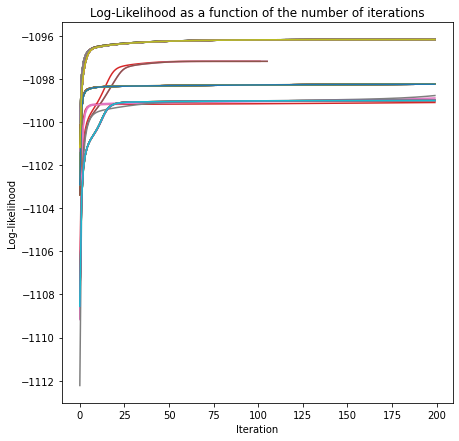

In [18]:
## Dataset
df = read_file('train', 'C')
X = df[['X1', 'X2']].values
y = df['Y'].values[:, None]

## Initialize
K = 3
GMM_ = GMM(K = K, max_iter = 200, tol = 1e-7, n_trials = 100)

## Train
GMM_.fit(X)
fig, ax = plt.subplots(figsize = (7, 7))
for idx, values in GMM_.likelihoods.items():
    ax.plot(values)
ax.set_title('Log-Likelihood as a function of the number of iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
idx_best = GMM_.get_best_trial()

Text(0.5, 1.0, 'Clusters and estimated gaussian confidence ellipse from GMM')

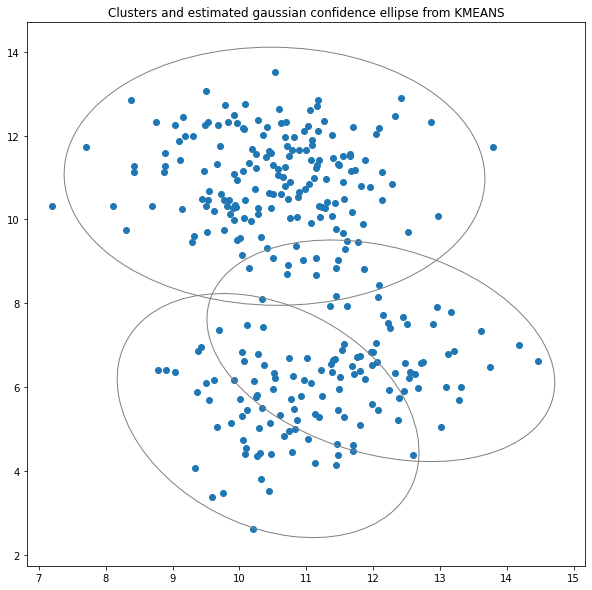

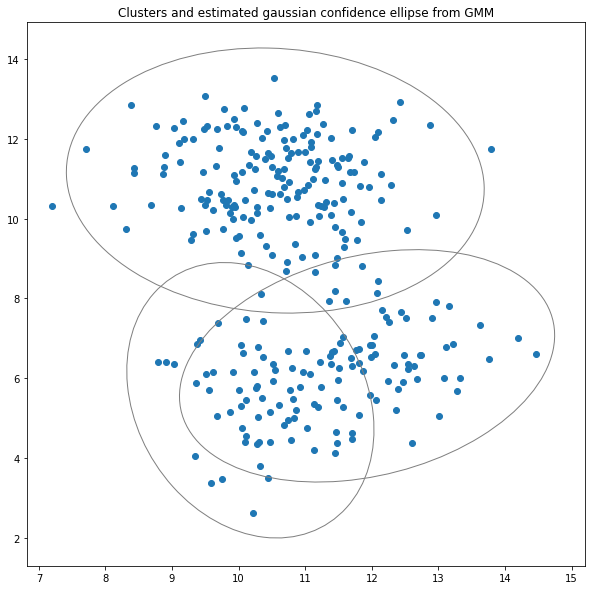

In [19]:
## Plot confidence ellipses
pis_ini, mus_ini, sigmas_ini = GMM_.kmeans[idx_best]
ax = confidence_ellipse(X, K, mus_ini, sigmas_ini, n_std = 3)
ax.set_title('Clusters and estimated gaussian confidence ellipse from KMEANS')
pis, mus, sigmas = GMM_.gmms[idx_best]
ax = confidence_ellipse(X, K, mus, sigmas, n_std = 3)
ax.set_title('Clusters and estimated gaussian confidence ellipse from GMM')

Text(0.5, 1.0, 'Gaussian Mixture estimation for K = 3')

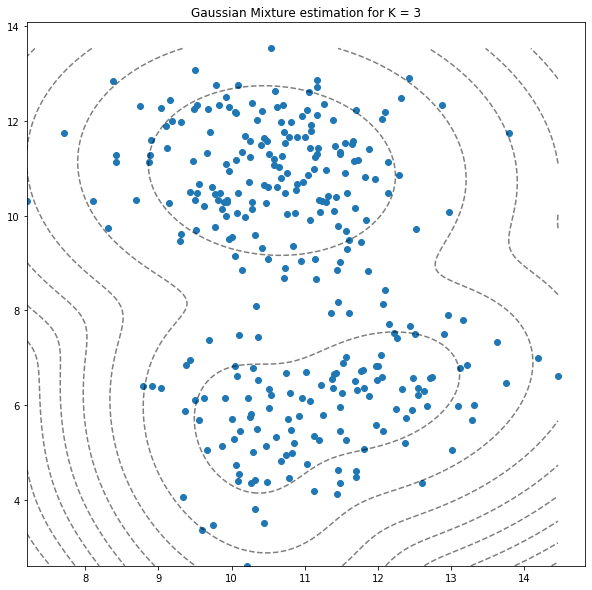

In [20]:
ax = mixture_plot(X, K, pis, mus, sigmas)
ax.set_title('Gaussian Mixture estimation for K = %s'% K)

We can try with 4 clusters :

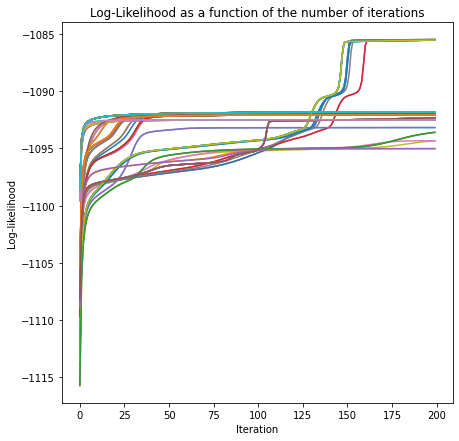

In [21]:
## Initialize
K = 4
GMM_ = GMM(K = K, max_iter = 200, tol = 1e-7, n_trials = 100)

## Train
GMM_.fit(X)
fig, ax = plt.subplots(figsize = (7, 7))
for idx, values in GMM_.likelihoods.items():
    ax.plot(values)
ax.set_title('Log-Likelihood as a function of the number of iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
idx_best = GMM_.get_best_trial()

In the above plot, we ensure ourselves that the log-likelihood keeps on increasing as we have seen in the proff for the GMM model.

Text(0.5, 1.0, 'Clusters and estimated gaussian confidence ellipse from GMM')

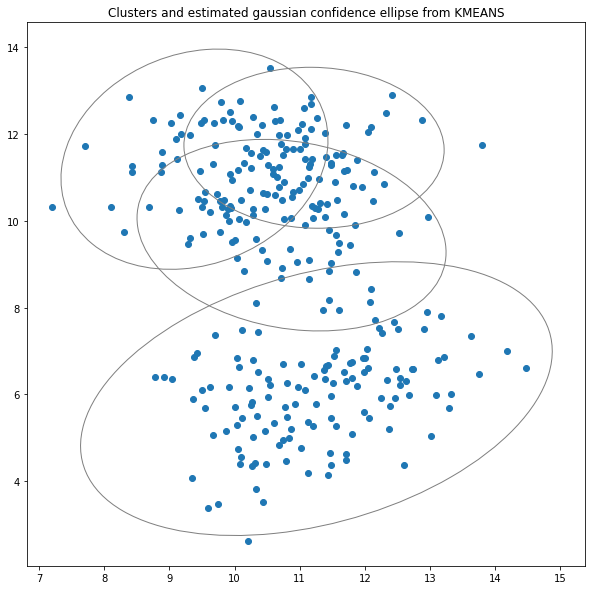

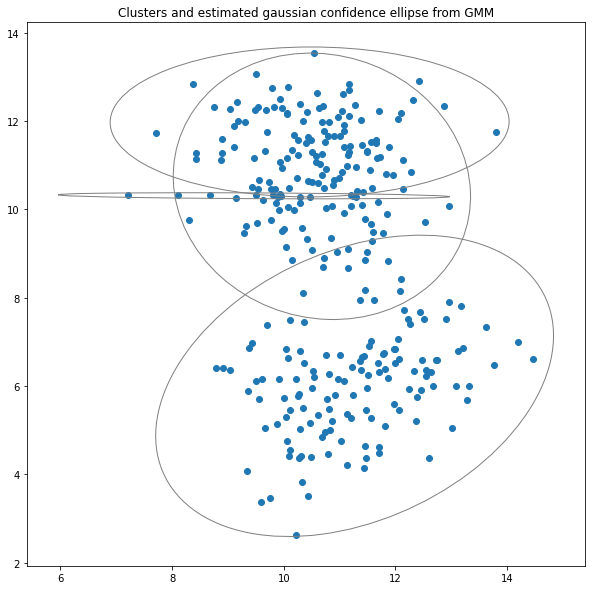

In [22]:
## Plot confidence ellipses
pis_ini, mus_ini, sigmas_ini = GMM_.kmeans[idx_best]
ax = confidence_ellipse(X, K, mus_ini, sigmas_ini, n_std = 3)
ax.set_title('Clusters and estimated gaussian confidence ellipse from KMEANS')
pis, mus, sigmas = GMM_.gmms[idx_best]
ax = confidence_ellipse(X, K, mus, sigmas, n_std = 3)
ax.set_title('Clusters and estimated gaussian confidence ellipse from GMM')

Text(0.5, 1.0, 'Gaussian Mixture estimation for K = 4')

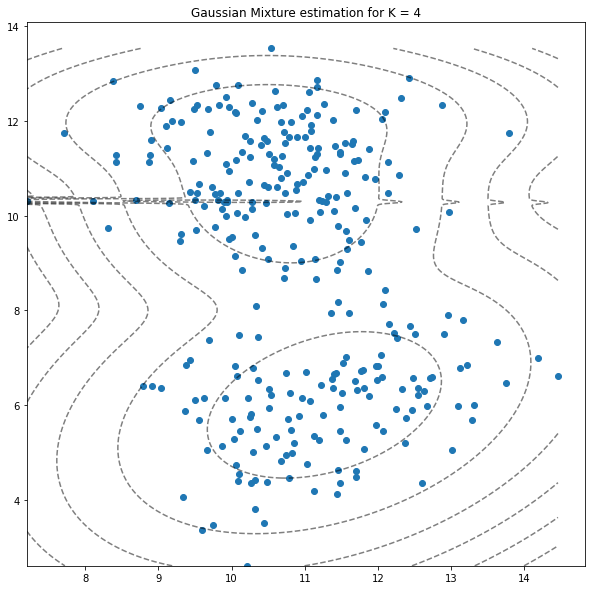

In [23]:
ax = mixture_plot(X, K, pis, mus, sigmas)
ax.set_title('Gaussian Mixture estimation for K = %s'% K)

### Decathlon Dataset (not normalized):
We can do the same steps as before. However this time, the points lie in an High Dimensional Space (11 dimensions) so we cannot plot them out of the box.

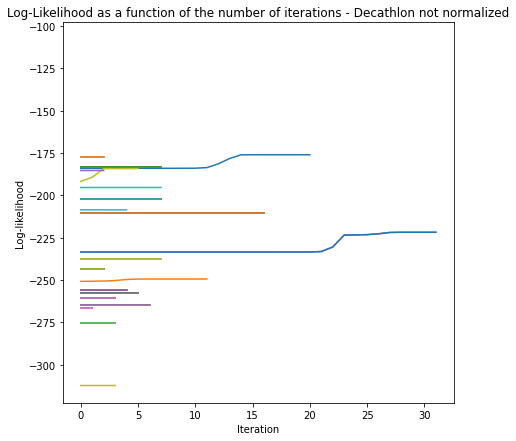

In [24]:
## load data : 
import pyreadr
K = 3
result = pyreadr.read_r('data/decathlon.RData')
X = result["X"].values


## Initialize
GMM_ = GMM(K = 3, max_iter = 200, tol = 1e-8, n_trials = 100)
## Train
GMM_.fit(X)
fig, ax = plt.subplots(figsize = (7, 7))
for idx, values in GMM_.likelihoods.items():
    ax.plot(values)
ax.set_title('Log-Likelihood as a function of the number of iterations - Decathlon not normalized')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
plt.show()

We can see different, trials of the GMM process. Sometimes, it converges really fast to a local minima but other times, it converges very slowly and can reach a plateau and continue to increase after some iterations.

If the data is not normalized, we can see in the covariances matrix that only some features (especially the last two ones) are used to cluster the points. That is because the features don't share the same unit, and the model discriminate more easily high values (are they are more spread).

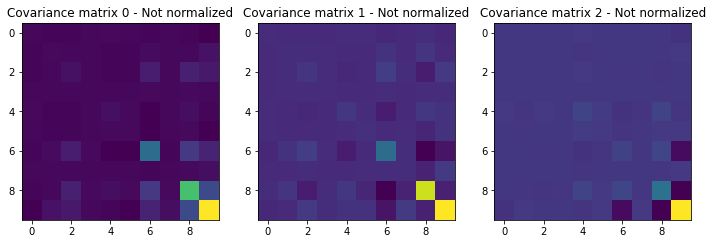

In [25]:
best_sigmas = GMM_.get_best_sigma()
fig, axs = plt.subplots(1, 3, figsize = (12, 12))
for k in range(GMM_.K):
    axs[k].imshow(best_sigmas[k])
    axs[k].set_title('Covariance matrix %s' % k + ' - Not normalized' )

### Decathlon Dataset (normalized):
This time we do a min-max scaling to ensure the features are in the interval [0, 1].

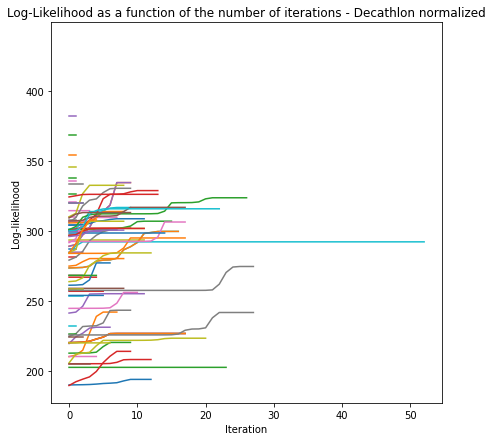

In [26]:
## load data : 
import pyreadr
K = 3
result = pyreadr.read_r('data/decathlon.RData')
data = result["X"].values
X = (data - np.min(data,axis=0)[None,:])/(np.max(data,axis=0)[None,:] - np.min(data,axis=0)[None,:])

## Initialize
GMM_ = GMM(K = 3, max_iter = 200, tol = 1e-8, n_trials = 100)
## Train
GMM_.fit(X)
fig, ax = plt.subplots(figsize = (7, 7))
for idx, values in GMM_.likelihoods.items():
    ax.plot(values)
ax.set_title('Log-Likelihood as a function of the number of iterations - Decathlon normalized')
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
plt.show()

We can see this time in the covariance matrixes,  that all the features are used to separate the points : 

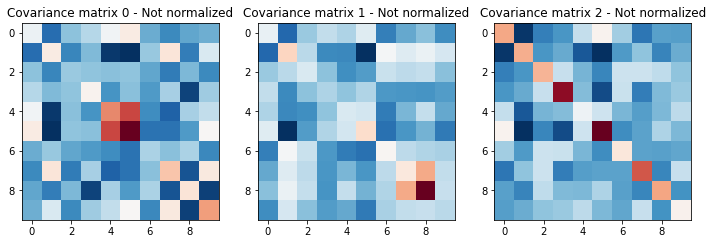

In [27]:
best_sigmas = GMM_.get_best_sigma()
fig, axs = plt.subplots(1, 3, figsize = (12, 12))
for k in range(GMM_.K):
    axs[k].imshow(best_sigmas[k],cmap='RdBu_r')
    axs[k].set_title('Covariance matrix %s' % k + ' - Not normalized' )

We can now plot the pairwise distributions of the points. In the first plot, we plot the estimated mixture model : 
$f(x) = \sum_{k=1}^K\pi_k\mathcal{N}(x, \mu_k, \sigma_k)$. And in the second one, we plot the gaussian ellipse for each class.
The color of the points indicates the estimated class. The gaussians used are the 2D gaussians extracted from the 11 multivariate gaussian.

<ipython-input-17-eb712484cbb9>:113: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[i, j].set_xticks([], [])
<ipython-input-17-eb712484cbb9>:114: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[i, j].set_yticks([], [])


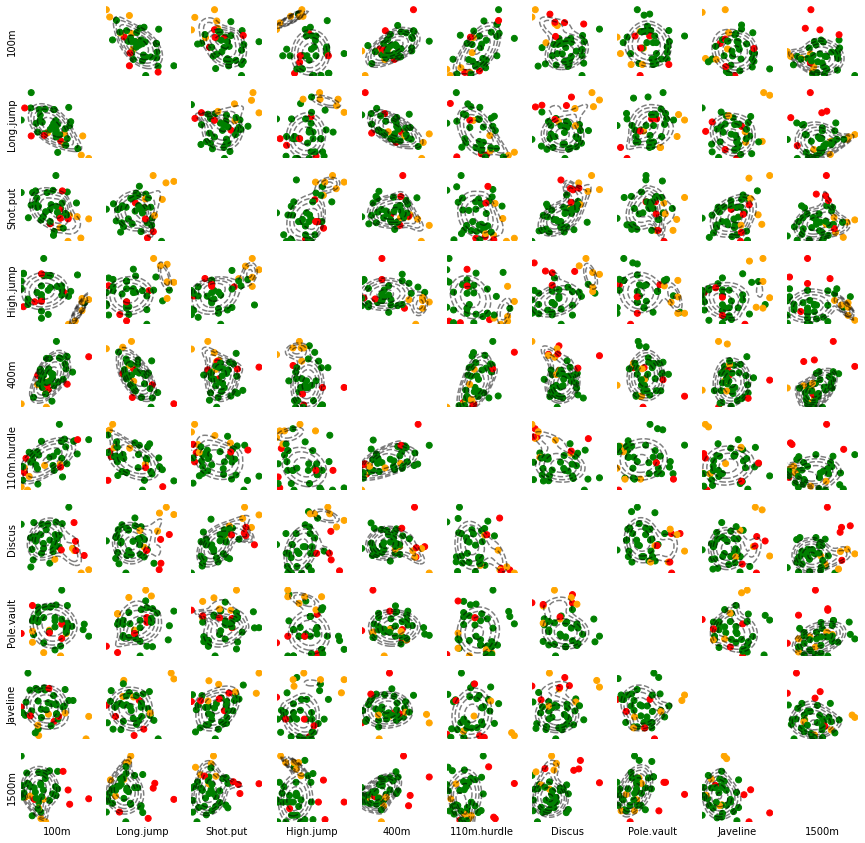

In [28]:
GMM_.plot_mixture_pairplot()

<ipython-input-17-eb712484cbb9>:146: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[i, j].set_xticks([], [])
<ipython-input-17-eb712484cbb9>:147: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[i, j].set_yticks([], [])


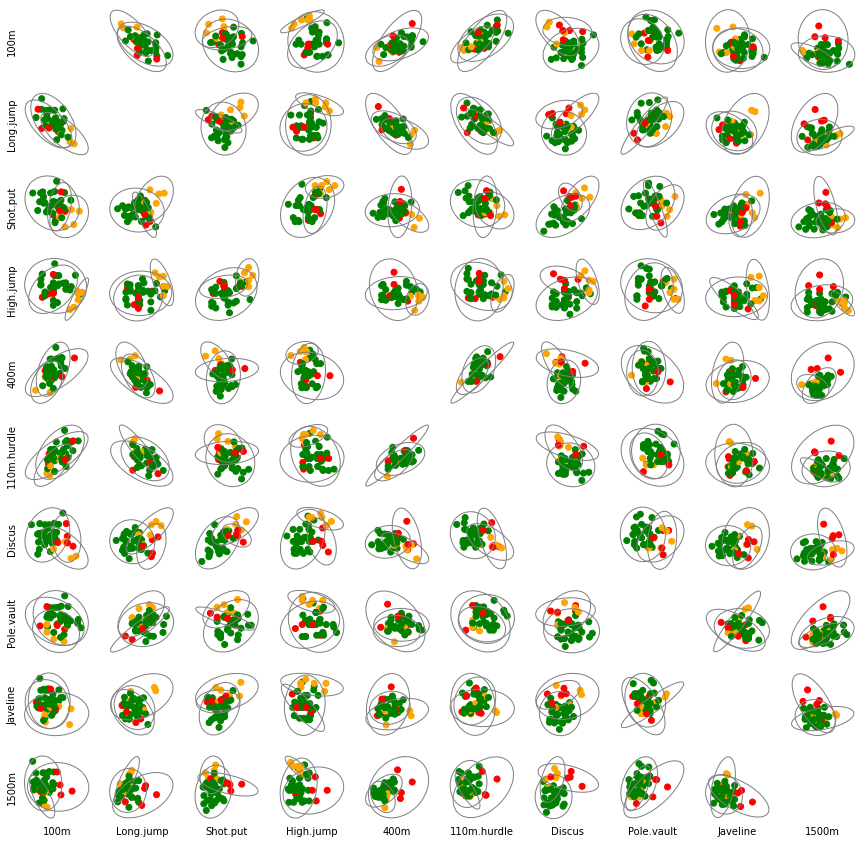

In [29]:
GMM_.plot_gaussian_pairplot()

As we can see, some pairwise features can be well estimated with the gaussian mixture. That is the case for 1500m \& Discus or 1500m and Shot put. But sometimes, this representation is not very effective : 110m hurdle \& 400m for example. 